# PR05 - Identifying suitable sites for new covid clinics

## Introduction

This notebook demonstrates how **geopy** and **geopandas** can perform network analysis to identify potential sites for new Covid19 clinics in the city of Barcelona.

## Libraries

In [1]:
# Numpy and Pandas
import numpy as np
import pandas as pd

# URL handling modules
import urllib.request
import os

# Import interactive computing
from IPython.core import display as ICD

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (25,10)

import seaborn as sns
import folium
import json

# Maps
import geopandas as gpd
import geoplot  as gplt

import geopy
from geopy.geocoders import Bing
from geopy.extra.rate_limiter import RateLimiter

# import warnings
# warnings.filterwarnings('ignore')

# Shapely to convert string lat-longs to Point objects
# from shapely.geometry import Point

In [2]:
# Options for DataFrame visualization:
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 40)
# Option to show not truncated cells in pandas
pd.set_option('display.max_colwidth', None)

## Datasets loading

## Spain Hospitals Data

In [3]:
def read_excel_sheets(xls,path):
    
    """Read all sheets of an Excel workbook"""
    
    
    print(f"Loading '{xls}' into pandas")
    print(40*'-')
    xl = pd.ExcelFile(xls_path)

    for idx, name in enumerate(xl.sheet_names):
        print(f'Sheet #{idx}: {name}')    

In [4]:
xls = 'CNH_2019.xls'
xls_path = 'input/'+ xls

In [5]:
read_excel_sheets(xls, xls_path)

Loading 'CNH_2019.xls' into pandas
----------------------------------------
Sheet #0: CATÁLOGO
Sheet #1: DOTACIÓN
Sheet #2: CCAA
Sheet #3: PROVINCIAS
Sheet #4: MUNICIPIOS
Sheet #5: FINALIDAD ASISTENCIAL
Sheet #6: DEPENDENCIA FUNCIONAL
Sheet #7: DEPENDENCIA_PATRIMONIAL


In [6]:
def create_df(xls_path):
    '''
    Return a DataFrames from every sheet
    '''
    
    # Read all sheets
    df_sheets = pd.read_excel(xls_path, sheet_name = None)
    
    # Print all dataframes
    for key, dataframe in df_sheets.items():
        print(key)
        ICD.display(dataframe)
    
    # Create a dictionary to select 
    return {key:dataframe for key, dataframe in df_sheets.items()}    

In [7]:
sheets_dict = create_df(xls_path)

CATÁLOGO


,CODCNH,NOMBRE,DIRECCION,TELEFONO,TELEFONO2,TELEFAX,CODMU,MUNICIPIOS,CODPROV,PROVINCIAS,CODAUTO,COMUNIDADES,CODPOSTAL,NCAMAS,CODFI,FINALIDAD ASISITENCIAL,CODPAT,DEPENDENCIA PATRIMONIAL,CODFU,DEPENDENCIA FUNCIONAL,...,CODIDCOM,ALTA,CERRADO,CAPITAL,CIERREFECH,CONCIERTO,EMAIL,TAC,RM,GAM,HEM,ASD,LIT,BCO,ALI,SPECT,PET,MAMOS,DO,DIAL
0,10035,RED DE SALUD MENTAL DE ARABA (HOSPITAL PSIQUIÁTRICO DE ARABA),"ÁLAVA, 43",945006555.0,NaN,945006587.0,10590,Vitoria-Gasteiz,1,ÁLAVA,16,PAÍS VASCO,1006,207,6,PSIQUIÁTRICO,6,COMUNIDAD AUTÓNOMA,4,SERVICIO VASCO DE SALUD-OSAKIDETZA,...,NaN,N,N,S,NaN,N,SECRETARIA.GERENCIA@osakidetza.eus,0,0,0,0,0,0,0,0,0,0,0,0,0
1,10040,HOSPITAL SAN JOSÉ,"BEATO TOMÁS DE ZUMÁRRAGA, 10",945140900.0,NaN,945145709.0,10590,Vitoria-Gasteiz,1,ÁLAVA,16,PAÍS VASCO,1008,63,12,MÉDICO-QUIRÚRGICO,14,PRIVADO NO BENÉFICO,23,PRIVADO NO BENÉFICO,...,NaN,N,N,S,NaN,N,diazdecorcueram@vithas.es,1,1,0,1,1,0,0,0,0,0,1,1,1
2,10053,HOSPITAL QUIRÓNSALUD VITORIA,"ESPERANZA, 3",945252500.0,NaN,945279260.0,10590,Vitoria-Gasteiz,1,ÁLAVA,16,PAÍS VASCO,1002,26,1,GENERAL,14,PRIVADO NO BENÉFICO,23,PRIVADO NO BENÉFICO,...,NaN,N,N,S,NaN,S,josecarlos.mellado@quironsalud.es,1,2,0,0,0,0,0,0,0,0,1,1,0
3,10066,"HOSPITAL DE CUIDADOS SAN ONOFRE, S.L. (HOSPITAL DE CUIDADOS SAN ONOFRE)","SALVATIERRABIDE, 9",945142100.0,NaN,945143318.0,10590,Vitoria-Gasteiz,1,ÁLAVA,16,PAÍS VASCO,1007,82,13,GERIATRÍA Y/O LARGA ESTANCIA,14,PRIVADO NO BENÉFICO,23,PRIVADO NO BENÉFICO,...,NaN,N,N,S,NaN,S,info@hospitalsanonofre.com,0,0,0,0,0,0,0,0,0,0,0,0,0
4,10088,HOSPITAL DE LEZA,"CTRA. VITORIA - LOGROÑO, KM. 59",945006900.0,945006876.0,945006901.0,10318,Laguardia,1,ÁLAVA,16,PAÍS VASCO,1309,63,1,GENERAL,6,COMUNIDAD AUTÓNOMA,4,SERVICIO VASCO DE SALUD-OSAKIDETZA,...,NaN,N,N,N,NaN,N,hospital.leza@osakidetza.eus,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,500195,HOSPITAL DE REHABILITACION PSIQUIATRICA PRISMA,"TORRE DEL CEREZO, Nº 17 Bº. DE SAN JUAN DE MOZARRIFAR",976151152.0,NaN,976151153.0,502973,Zaragoza,50,ZARAGOZA,2,ARAGÓN,50820,50,6,PSIQUIÁTRICO,14,PRIVADO NO BENÉFICO,23,PRIVADO NO BENÉFICO,...,NaN,N,N,S,NaN,N,administracion@hospitalprisma.com,0,0,0,0,0,0,0,0,0,0,0,0,0
920,500200,CENTRO SANITARIO CINCO VILLAS,"ANTONIO MACHADO, S/N",976677978.0,976677973.0,976677972.0,500956,Ejea de los Caballeros,50,ZARAGOZA,2,ARAGÓN,50600,32,16,OTRA FINALIDAD,6,COMUNIDAD AUTÓNOMA,30,SERVICIO ARAGONÉS DE SALUD-SALUD,...,NaN,N,N,N,NaN,N,NaN,1,1,0,0,0,0,0,0,0,0,1,0,0
921,500218,HOSPITAL VIAMED MONTECANAL,"C/ FRANZ SCHUBERT, 2",876241818.0,NaN,876241822.0,502973,Zaragoza,50,ZARAGOZA,2,ARAGÓN,50012,68,1,GENERAL,14,PRIVADO NO BENÉFICO,23,PRIVADO NO BENÉFICO,...,NaN,N,N,S,NaN,S,admi@viamedmontecanal.com,1,1,0,1,1,0,0,0,0,0,1,0,0
922,510039,HOSPITAL UNIVERSITARIO DE CEUTA,"LOMA COLMENAR, S/N",856907000.0,NaN,856907066.0,510013,Ceuta,51,CEUTA,18,CEUTA,51003,252,1,GENERAL,1,SEGURIDAD SOCIAL,1,INSTITUTO DE GESTIÓN SANITARIA-INGESA,...,NaN,N,N,S,NaN,N,NaN,1,1,0,0,0,0,0,0,0,0,1,1,0


DOTACIÓN


,CODCNH,TAC,RM,GAM,HEM,ASD,LIT,BCO,ALI,SPECT,PET,MAMOS,DO,OTRA,DIAL
0,500140,1,0,0,0,0,0,0,0,0,0,1,1,NaN,10
1,500153,1,1,0,0,0,0,0,0,0,0,1,0,NaN,12
2,500188,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0
3,500195,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0
4,520018,1,0,0,0,0,0,0,0,0,0,1,0,NaN,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,82189,0,0,0,0,0,0,0,0,0,0,0,0,0,0
920,170334,1,1,0,0,0,0,0,0,0,0,1,0,0,14
921,82190,0,0,0,0,0,0,0,0,0,0,0,0,0,0
922,460404,1,2,0,1,1,0,0,1,0,0,1,1,NaN,0


CCAA


,CODAUTO,AUTONOMIA,TEXTO_AUTONOMIA
0,1,ANDALUCÍA,COMUNIDAD AUTÓNOMA DE ANDALUCÍA
1,2,ARAGÓN,COMUNIDAD AUTÓNOMA DE ARAGÓN
2,3,PPDO. DE ASTURIAS,PRINCIPADO DE ASTURIAS
3,4,ILLES BALEARS,COMUNIDAD AUTÓNOMA DE LAS ILLES BALEARS
4,5,CANARIAS,COMUNIDAD AUTÓNOMA DE CANARIAS
5,6,CANTABRIA,COMUNIDAD AUTÓNOMA DE CANTABRIA
6,7,CASTILLA Y LEÓN,COMUNIDAD AUTÓNOMA DE CASTILLA Y LEÓN
7,8,CASTILLA-LA MANCHA,COMUNIDAD AUTÓNOMA DE CASTILLA-LA MANCHA
8,9,CATALUÑA,COMUNIDAD AUTÓNOMA DE CATALUÑA
9,10,COMUNIDAD VALENCIANA,COMUNIDAD AUTÓNOMA DE VALENCIA


PROVINCIAS


,CODPROV,NOMBRE,CODAUTO
0,1,ÁLAVA,16
1,2,ALBACETE,8
2,3,ALICANTE,10
3,4,ALMERÍA,1
4,5,ÁVILA,7
5,6,BADAJOZ,11
6,7,ILLES BALEARS,4
7,8,BARCELONA,9
8,9,BURGOS,7
9,10,CÁCERES,11


MUNICIPIOS


,CODMU,MUNICIPIO,CODPROV
0,440012,Ababuj,44
1,400019,Abades,40
2,100015,Abadía,10
3,270018,Abadín,27
4,480010,Abadiño,48
...,...,...,...
8112,200816,Zumaia,20
8113,200809,Zumarraga,20
8114,94859,Zuñeda,9
8115,312652,Zúñiga,31


FINALIDAD ASISTENCIAL


,CODFI,DESFI
0,1,GENERAL
1,2,QUIRÚRGICO
2,3,MATERNAL
3,4,INFANTIL
4,5,MATERNO-INFANTIL
5,6,PSIQUIÁTRICO
6,7,ENFERMEDADES DEL TORAX
7,8,ONCOLÓGICO
8,9,OFTÁLMICO U ORL
9,10,TRAUMATOLOGÍA Y/O REHABILITACIÓN


DEPENDENCIA FUNCIONAL


,CODFU,DESFU
0,1,INSTITUTO DE GESTIÓN SANITARIA-INGESA
1,2,SERVICIO ANDALUZ DE SALUD
2,3,INSTITUTO CATALÁN DE LA SALUD
3,4,SERVICIO VASCO DE SALUD-OSAKIDETZA
4,5,CONSELLERIA DE SANIDAD. G. VALENCIANA
5,6,SERVICIO NAVARRO DE SALUD-OSASUNBIDEA
6,7,SERVICIO GALLEGO DE SALUD-SERGAS
7,8,SERVICIO CANARIO DE SALUD
8,12,INSTITUTO DE SALUD CARLOS III
9,13,OTROS HOSPITALES PÚBLICOS DE DEPENDENCIA ESTATAL


DEPENDENCIA_PATRIMONIAL


,CODPAT,DESDE
0,1,SEGURIDAD SOCIAL
1,2,INSTITUTO DE SALUD CARLOS III
2,3,MINISTERIO DE EDUCACIÓN Y CIENCIA
3,4,MINISTERIO DE INTERIOR
4,5,MINISTERIO DE DEFENSA
5,6,COMUNIDAD AUTÓNOMA
6,7,DIPUTACIÓN O CABILDO
7,8,MUNICIPIO
8,9,ENTIDADES PÚBLICAS
9,10,MATEP


'CATÁLOGO' is the sheet that resume the content of all the other sheets

In [8]:
hospitals_df=sheets_dict['CATÁLOGO']
hospitals_df.head()

,CODCNH,NOMBRE,DIRECCION,TELEFONO,TELEFONO2,TELEFAX,CODMU,MUNICIPIOS,CODPROV,PROVINCIAS,CODAUTO,COMUNIDADES,CODPOSTAL,NCAMAS,CODFI,FINALIDAD ASISITENCIAL,CODPAT,DEPENDENCIA PATRIMONIAL,CODFU,DEPENDENCIA FUNCIONAL,...,CODIDCOM,ALTA,CERRADO,CAPITAL,CIERREFECH,CONCIERTO,EMAIL,TAC,RM,GAM,HEM,ASD,LIT,BCO,ALI,SPECT,PET,MAMOS,DO,DIAL
0,10035,RED DE SALUD MENTAL DE ARABA (HOSPITAL PSIQUIÁTRICO DE ARABA),"ÁLAVA, 43",945006555.0,NaN,945006587.0,10590,Vitoria-Gasteiz,1,ÁLAVA,16,PAÍS VASCO,1006,207,6,PSIQUIÁTRICO,6,COMUNIDAD AUTÓNOMA,4,SERVICIO VASCO DE SALUD-OSAKIDETZA,...,NaN,N,N,S,NaN,N,SECRETARIA.GERENCIA@osakidetza.eus,0,0,0,0,0,0,0,0,0,0,0,0,0
1,10040,HOSPITAL SAN JOSÉ,"BEATO TOMÁS DE ZUMÁRRAGA, 10",945140900.0,NaN,945145709.0,10590,Vitoria-Gasteiz,1,ÁLAVA,16,PAÍS VASCO,1008,63,12,MÉDICO-QUIRÚRGICO,14,PRIVADO NO BENÉFICO,23,PRIVADO NO BENÉFICO,...,NaN,N,N,S,NaN,N,diazdecorcueram@vithas.es,1,1,0,1,1,0,0,0,0,0,1,1,1
2,10053,HOSPITAL QUIRÓNSALUD VITORIA,"ESPERANZA, 3",945252500.0,NaN,945279260.0,10590,Vitoria-Gasteiz,1,ÁLAVA,16,PAÍS VASCO,1002,26,1,GENERAL,14,PRIVADO NO BENÉFICO,23,PRIVADO NO BENÉFICO,...,NaN,N,N,S,NaN,S,josecarlos.mellado@quironsalud.es,1,2,0,0,0,0,0,0,0,0,1,1,0
3,10066,"HOSPITAL DE CUIDADOS SAN ONOFRE, S.L. (HOSPITAL DE CUIDADOS SAN ONOFRE)","SALVATIERRABIDE, 9",945142100.0,NaN,945143318.0,10590,Vitoria-Gasteiz,1,ÁLAVA,16,PAÍS VASCO,1007,82,13,GERIATRÍA Y/O LARGA ESTANCIA,14,PRIVADO NO BENÉFICO,23,PRIVADO NO BENÉFICO,...,NaN,N,N,S,NaN,S,info@hospitalsanonofre.com,0,0,0,0,0,0,0,0,0,0,0,0,0
4,10088,HOSPITAL DE LEZA,"CTRA. VITORIA - LOGROÑO, KM. 59",945006900.0,945006876.0,945006901.0,10318,Laguardia,1,ÁLAVA,16,PAÍS VASCO,1309,63,1,GENERAL,6,COMUNIDAD AUTÓNOMA,4,SERVICIO VASCO DE SALUD-OSAKIDETZA,...,NaN,N,N,N,NaN,N,hospital.leza@osakidetza.eus,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
hospitals_df.COMUNIDADES.unique()

array(['PAÍS VASCO', 'CASTILLA-LA MANCHA', 'COMUNIDAD VALENCIANA',
       'ANDALUCÍA', 'CASTILLA Y LEÓN', 'EXTREMADURA', 'ILLES BALEARS',
       'CATALUÑA', 'GALICIA', 'ARAGÓN', 'LA RIOJA', 'MADRID',
       'REGIÓN DE MURCIA', 'C. FORAL DE NAVARRA', 'PPDO. DE ASTURIAS',
       'CANARIAS', 'CANTABRIA', 'CEUTA', 'MELILLA'], dtype=object)

### Geocoding

**Geocoding** is the computational process of transforming a physical address description to a location on the Earth’s surface (spatial representation in numerical coordinates) 

To geolocate a single address, you can use Geopy python library.

First, create the column 'address' for geocoding.

In [10]:
hospitals_df.CODPOSTAL= '0'+hospitals_df.CODPOSTAL.astype(str)

In [11]:
hospitals_df['address']= hospitals_df['DIRECCION'] + ',' + \
                         hospitals_df['MUNICIPIOS'] + ',' + \
                         hospitals_df['CODPOSTAL']

### API Key Bing Maps

In [12]:
api_key = '...'

In [13]:
# Geocoding Service - Bing
locator = Bing(api_key=api_key, timeout=30)
# RateLimiter: not overload the API with too many requests
geocode = RateLimiter(locator.geocode, min_delay_seconds=2)

In [14]:
# def geocoding(df):

#     '''
#     Function that returns a location from an address will repeat until success
#     '''
#     #  Function to delay between geocoding calls (for a large number of addresses)
#     df['location'] = df['address'].apply(geocode)
            
#     # Create longitude, latitude and altitude from location column (returns tuple)
#     df['point'] = df['location'].apply(lambda loc: tuple(loc.point) if loc else None)

#     # Split point column into latitude, longitude columns
#     df[['Latitude', 'Longitude','Altitude']] = pd.DataFrame(df['point'].tolist(), index=df.index) 

#     return df 

In [15]:
# gc_hospitals = geocoding(hospitals_df)
# gc_hospitals

The above code produces a Dataframe with latitude and longitude columns that you can map with any Geographic visualisation tool.

### Saving Dataset

Saving the dataset for future use.

In [16]:
# gc_hospitals.to_csv('output/geocoding_spanish_hospitals.csv', index=False) 

## COVID19 data

Collection of COVID19 data by provinces in Spain https://github.com/montera34/escovid19data

In [17]:
def download_url_file(url, path, name = '', extension = ''):
    """
    Gets file from its link and downloads it to the
    specified folder under the specified name.
    Credits: Javi TA!
    """

    name = os.path.splitext(url)[0].rsplit('/', 1)[-1]
    extension = os.path.splitext(url)[1]
    urllib.request.urlretrieve(url, f'{path}{name}{extension}')

In [18]:
url_prov = 'https://raw.githubusercontent.com/montera34/escovid19data/master/data/output/covid19-provincias-spain_consolidated.csv'
path = 'input/'

In [19]:
download_url_file(url_prov, path)

In [20]:
patients_df = pd.read_csv('input/covid19-provincias-spain_consolidated.csv', parse_dates=['date'])
patients_df.head()

,date,province,ine_code,ccaa,new_cases,PCR,TestAc,activos,hospitalized,intensive_care,deceased,cases_accumulated,cases_accumulated_PCR,recovered,num_casos,num_casos_prueba_pcr,num_casos_prueba_test_ac,num_casos_prueba_otras,num_casos_prueba_desconocida,poblacion,...,intensive_care_per_1000000,deceassed_per_100000,hospitalized_per_100000,cases_14days,cases_7days,cases_PCR_14days,cases_PCR_7days,daily_cases,daily_cases_avg7,daily_cases_PCR,daily_cases_PCR_avg7,daily_deaths,daily_deaths_inc,daily_deaths_avg3,daily_deaths_avg7,deaths_last_week,num_casos_prueba_pcr_avg7,source_name,source,comments
0,2020-01-31,Albacete,2,Castilla - La Mancha,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,388167,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ISCIII RENAVE,https://cnecovid.isciii.es/covid19/resources/datos_provincias.csv,NaN
1,2020-01-31,Alicante/Alacant,3,Comunitat Valenciana,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1858683,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ISCIII RENAVE,https://cnecovid.isciii.es/covid19/resources/datos_provincias.csv,NaN
2,2020-01-31,Almería,4,Andalucía,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,716820,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ISCIII RENAVE,https://cnecovid.isciii.es/covid19/resources/datos_provincias.csv,NaN
3,2020-01-31,Araba/Álava,1,País Vasco,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,331549,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ISCIII RENAVE,https://cnecovid.isciii.es/covid19/resources/datos_provincias.csv,NaN
4,2020-01-31,Asturias,33,"Asturias, Principado de",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1022800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ISCIII RENAVE,https://cnecovid.isciii.es/covid19/resources/datos_provincias.csv,NaN


In [21]:
patients_df.ccaa.unique()

array(['Castilla - La Mancha', 'Comunitat Valenciana', 'Andalucía',
       'País Vasco', 'Asturias, Principado de', 'Castilla y León',
       'Extremadura', 'Balears, Illes', 'Cataluña', 'Cantabria', 'Ceuta',
       'Galicia', 'Aragón', 'Madrid, Comunidad de', 'Melilla',
       'Murcia, Región de', 'Navarra, Comunidad Foral de', 'Canarias',
       'Rioja, La'], dtype=object)

In [22]:
patients_df=patients_df.replace({'Rioja, La': 'La Rioja'})
patients_df.ccaa.unique()

array(['Castilla - La Mancha', 'Comunitat Valenciana', 'Andalucía',
       'País Vasco', 'Asturias, Principado de', 'Castilla y León',
       'Extremadura', 'Balears, Illes', 'Cataluña', 'Cantabria', 'Ceuta',
       'Galicia', 'Aragón', 'Madrid, Comunidad de', 'Melilla',
       'Murcia, Región de', 'Navarra, Comunidad Foral de', 'Canarias',
       'La Rioja'], dtype=object)

**Variables**

Original data:

- `date` | Day in yyyy-mm-dd format

- `province` | Province

- `ine_code` | INE code of the province

- `ccaa` | Region

- `new_cases`  | Number of new COVID-19 cases

- `PCR` | Number of new COVID-19 cases detected with PCR

- `TestAc` | Number of new COVID-19 cases detected with Ac

- `activos` | Active COVID-19 cases

- `hospitalized` | Hospitalized

- `intensive_care` | UCI (intensive care patients)

- `deceased` Deaths (cumulative)

- `cases_accumulated` Casos COVID-19 detectados acumulado | Number of new COVID-19 cases (cumulative)

- `cases_accumulated_PCR` | Number of new COVID-19 cases detected with PCR (cumulative)

- `recovered` Recuperados | Recovered

- `poblacion` Población de la provincia | Inhabitants of the province


Datos de RENAVE-ISCIII: la fecha de inicio de síntomas o, en su defecto, la fecha de diagnóstico menos 6 días (con prefijo num_) (fuente: https://cnecovid.isciii.es/covid19/resources/datos_provincias.csv),

- `num_casos` el número de casos totales, confirmados o probables

- `num_casos_prueba_pcr` el número de casos con prueba de laboratorio PCR o técnicas moleculares

- `num_casos_prueba_test_ac` el número de casos con prueba de laboratorio de test rápido de anticuerpos

- `num_casos_prueba_otras` el número de casos con otras pruebas de laboratorio, mayoritariamente por detección de antígeno o técnica Elisa

- `num_casos_prueba_desconocida` el número de casos sin información sobre la prueba de laboratorio


Calculated data:

- `cases_per_cienmil` | Cumulative cases per 100,000 inhabitants

- `intensive_care_per_100000` | Intensive care per 100,000 inhabitants

- `hospitalized_per_100000` | Intensive care per 100,000 inhabitants Ver | View wiki

- `deceassed_per_100000` | Cumulative deaths per 100,000 inhabitants

- `cases_14days` | Detected cases in the last 14 days

- `daily_cases` | Daily cases. Calculated as a difference of cumulative cases reported.

- `daily_cases_avg7` | Average daily cases in the last 7 days (rolling average 7 days)

- `daily_cases_PCR_avg7` | Average daily cases PCR in the last 7 days (rolling average 7 days)

- `daily_deaths` | Daily deaths. Calculated as a difference of cumulative deaths reported.

- `daily_deaths_inc` | Calculated as the percentage from last day

- `daily_deaths_avg3` | Average daily deaths in the last 3 days (rolling average 3 days)

- `daily_deaths_avg6` | Average daily deaths in the last 7 days (rolling average 7 days)

- `deaths_last_week` | Deaths in the last 7 days.

- `num_casos_prueba_pcr_avg7` Media de casos (ventana de 7 días) de casos con prueba de laboratorio PCR o técnicas moleculares de los datos de RENAVE-ISCIII

Fuente de los datos y comentarios | Data sources and comments:

- `source_name` | Name of source of information, separated by ;

- `source` | Source URL of information, separated by ;

- `comments` | Comments of the data

## Preliminary Data Processing

## 1.Hospitals

### Importing Dataset

In [23]:
hosp_df = pd.read_csv('output/geocoding_spanish_hospitals.csv')
hosp_df.head(2)

,CODCNH,NOMBRE,DIRECCION,TELEFONO,TELEFONO2,TELEFAX,CODMU,MUNICIPIOS,CODPROV,PROVINCIAS,CODAUTO,COMUNIDADES,CODPOSTAL,NCAMAS,CODFI,FINALIDAD ASISITENCIAL,CODPAT,DEPENDENCIA PATRIMONIAL,CODFU,DEPENDENCIA FUNCIONAL,...,EMAIL,TAC,RM,GAM,HEM,ASD,LIT,BCO,ALI,SPECT,PET,MAMOS,DO,DIAL,address,location,point,Latitude,Longitude,Altitude
0,10035,RED DE SALUD MENTAL DE ARABA (HOSPITAL PSIQUIÁTRICO DE ARABA),"ÁLAVA, 43",945006555.0,NaN,945006587.0,10590,Vitoria-Gasteiz,1,ÁLAVA,16,PAÍS VASCO,1006,207,6,PSIQUIÁTRICO,6,COMUNIDAD AUTÓNOMA,4,SERVICIO VASCO DE SALUD-OSAKIDETZA,...,SECRETARIA.GERENCIA@osakidetza.eus,0,0,0,0,0,0,0,0,0,0,0,0,0,"ÁLAVA, 43,Vitoria-Gasteiz,01006","Araba Kalea 43, Vitoria, País Vasco / Euskadi 01006, Spain","(42.8361152, -2.678953, 0.0)",42.836115,-2.678953,0.0
1,10040,HOSPITAL SAN JOSÉ,"BEATO TOMÁS DE ZUMÁRRAGA, 10",945140900.0,NaN,945145709.0,10590,Vitoria-Gasteiz,1,ÁLAVA,16,PAÍS VASCO,1008,63,12,MÉDICO-QUIRÚRGICO,14,PRIVADO NO BENÉFICO,23,PRIVADO NO BENÉFICO,...,diazdecorcueram@vithas.es,1,1,0,1,1,0,0,0,0,0,1,1,1,"BEATO TOMÁS DE ZUMÁRRAGA, 10,Vitoria-Gasteiz,01008","Calle del Beato Tomás de Zumárraga 10, Vitoria, País Vasco / Euskadi 01008, Spain","(42.8496892, -2.6766448, 0.0)",42.849689,-2.676645,0.0


### Dimensions' reduction

In [24]:
hosp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924 entries, 0 to 923
Data columns (total 49 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CODCNH                   924 non-null    int64  
 1   NOMBRE                   924 non-null    object 
 2   DIRECCION                924 non-null    object 
 3   TELEFONO                 922 non-null    float64
 4   TELEFONO2                350 non-null    float64
 5   TELEFAX                  858 non-null    float64
 6   CODMU                    924 non-null    int64  
 7   MUNICIPIOS               924 non-null    object 
 8   CODPROV                  924 non-null    int64  
 9   PROVINCIAS               924 non-null    object 
 10  CODAUTO                  924 non-null    int64  
 11  COMUNIDADES              924 non-null    object 
 12  CODPOSTAL                924 non-null    int64  
 13  NCAMAS                   924 non-null    int64  
 14  CODFI                    9

In [25]:
# hosp_df.isnull().sum()

Re-ordering and selecting only interesting columns for the analysis.

In [26]:
hosp_df = hosp_df[['CODCNH', 'NOMBRE', 'Latitude', 'Longitude', 'MUNICIPIOS', 'CODPROV', 'PROVINCIAS','NCAMAS','FINALIDAD ASISITENCIAL','CERRADO']]
hosp_df.head()

,CODCNH,NOMBRE,Latitude,Longitude,MUNICIPIOS,CODPROV,PROVINCIAS,NCAMAS,FINALIDAD ASISITENCIAL,CERRADO
0,10035,RED DE SALUD MENTAL DE ARABA (HOSPITAL PSIQUIÁTRICO DE ARABA),42.836115,-2.678953,Vitoria-Gasteiz,1,ÁLAVA,207,PSIQUIÁTRICO,N
1,10040,HOSPITAL SAN JOSÉ,42.849689,-2.676645,Vitoria-Gasteiz,1,ÁLAVA,63,MÉDICO-QUIRÚRGICO,N
2,10053,HOSPITAL QUIRÓNSALUD VITORIA,42.849755,-2.668275,Vitoria-Gasteiz,1,ÁLAVA,26,GENERAL,N
3,10066,"HOSPITAL DE CUIDADOS SAN ONOFRE, S.L. (HOSPITAL DE CUIDADOS SAN ONOFRE)",42.843306,-2.682903,Vitoria-Gasteiz,1,ÁLAVA,82,GERIATRÍA Y/O LARGA ESTANCIA,N
4,10088,HOSPITAL DE LEZA,42.558244,-2.587001,Laguardia,1,ÁLAVA,63,GENERAL,N


### Changing columns names

In [27]:
hosp_df.columns

Index(['CODCNH', 'NOMBRE', 'Latitude', 'Longitude', 'MUNICIPIOS', 'CODPROV', 'PROVINCIAS', 'NCAMAS', 'FINALIDAD ASISITENCIAL', 'CERRADO'], dtype='object')

In [28]:
# to lower case, snake case, strip spaces
new_col_names = [x.lower().replace(' ', '_') for x in list(hosp_df.columns)]
hosp_df.columns = new_col_names

In [29]:
hosp_df.head()

,codcnh,nombre,latitude,longitude,municipios,codprov,provincias,ncamas,finalidad_asisitencial,cerrado
0,10035,RED DE SALUD MENTAL DE ARABA (HOSPITAL PSIQUIÁTRICO DE ARABA),42.836115,-2.678953,Vitoria-Gasteiz,1,ÁLAVA,207,PSIQUIÁTRICO,N
1,10040,HOSPITAL SAN JOSÉ,42.849689,-2.676645,Vitoria-Gasteiz,1,ÁLAVA,63,MÉDICO-QUIRÚRGICO,N
2,10053,HOSPITAL QUIRÓNSALUD VITORIA,42.849755,-2.668275,Vitoria-Gasteiz,1,ÁLAVA,26,GENERAL,N
3,10066,"HOSPITAL DE CUIDADOS SAN ONOFRE, S.L. (HOSPITAL DE CUIDADOS SAN ONOFRE)",42.843306,-2.682903,Vitoria-Gasteiz,1,ÁLAVA,82,GERIATRÍA Y/O LARGA ESTANCIA,N
4,10088,HOSPITAL DE LEZA,42.558244,-2.587001,Laguardia,1,ÁLAVA,63,GENERAL,N


## 2.Covid19 Patients

In [30]:
patients_df.columns

Index(['date', 'province', 'ine_code', 'ccaa', 'new_cases', 'PCR', 'TestAc', 'activos', 'hospitalized', 'intensive_care', 'deceased', 'cases_accumulated', 'cases_accumulated_PCR', 'recovered', 'num_casos', 'num_casos_prueba_pcr', 'num_casos_prueba_test_ac', 'num_casos_prueba_otras', 'num_casos_prueba_desconocida', 'poblacion', 'cases_per_cienmil', 'intensive_care_per_1000000', 'deceassed_per_100000', 'hospitalized_per_100000', 'cases_14days', 'cases_7days', 'cases_PCR_14days', 'cases_PCR_7days', 'daily_cases', 'daily_cases_avg7', 'daily_cases_PCR', 'daily_cases_PCR_avg7', 'daily_deaths', 'daily_deaths_inc', 'daily_deaths_avg3', 'daily_deaths_avg7', 'deaths_last_week', 'num_casos_prueba_pcr_avg7', 'source_name', 'source', 'comments'], dtype='object')

Re-ordering and selecting only interesting columns for the analysis.

### Changing column names

In [31]:
patients_df = patients_df.rename(columns = {'cases_per_cienmil':'cases_per_100000'})

In [32]:
patients_df=patients_df[['date','province', 'ine_code', 'ccaa', 'new_cases', 'activos', 'hospitalized', 'intensive_care', 'deceased', 'poblacion',
       'cases_per_100000', 'intensive_care_per_1000000', 'deceassed_per_100000', 'hospitalized_per_100000']]
patients_df

,date,province,ine_code,ccaa,new_cases,activos,hospitalized,intensive_care,deceased,poblacion,cases_per_100000,intensive_care_per_1000000,deceassed_per_100000,hospitalized_per_100000
0,2020-01-31,Albacete,2,Castilla - La Mancha,NaN,NaN,NaN,NaN,NaN,388167,NaN,NaN,NaN,NaN
1,2020-01-31,Alicante/Alacant,3,Comunitat Valenciana,NaN,NaN,NaN,NaN,NaN,1858683,NaN,NaN,NaN,NaN
2,2020-01-31,Almería,4,Andalucía,NaN,NaN,NaN,NaN,NaN,716820,NaN,NaN,NaN,NaN
3,2020-01-31,Araba/Álava,1,País Vasco,NaN,NaN,NaN,NaN,NaN,331549,NaN,NaN,NaN,NaN
4,2020-01-31,Asturias,33,"Asturias, Principado de",NaN,NaN,NaN,NaN,NaN,1022800,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13723,2020-10-20,Toledo,45,Castilla - La Mancha,NaN,NaN,326.0,28.0,994.0,694844,NaN,4.03,143.05,46.92
13724,2020-10-20,Valencia/València,46,Comunitat Valenciana,816.0,NaN,358.0,52.0,877.0,2565124,1103.1,2.03,34.19,13.96
13725,2020-10-20,Valladolid,47,Castilla y León,288.0,NaN,240.0,46.0,524.0,519546,NaN,8.85,100.86,46.19
13726,2020-10-20,Zamora,49,Castilla y León,13.0,NaN,84.0,4.0,150.0,172539,NaN,2.32,86.94,48.68


## Exploratory Data Analysis (EDA)

## Merge Dataframes

In [33]:
df = pd.merge(patients_df, hosp_df.set_index('codprov'), left_on='ine_code', right_index=True)
df.head()

,date,province,ine_code,ccaa,new_cases,activos,hospitalized,intensive_care,deceased,poblacion,cases_per_100000,intensive_care_per_1000000,deceassed_per_100000,hospitalized_per_100000,codcnh,nombre,latitude,longitude,municipios,provincias,ncamas,finalidad_asisitencial,cerrado
0,2020-01-31,Albacete,2,Castilla - La Mancha,NaN,NaN,NaN,NaN,NaN,388167,NaN,NaN,NaN,NaN,20019,COMPLEJO HOSPITALARIO UNIVERSITARIO DE ALBACETE,38.994778,-1.872875,Albacete,ALBACETE,705,GENERAL,N
0,2020-01-31,Albacete,2,Castilla - La Mancha,NaN,NaN,NaN,NaN,NaN,388167,NaN,NaN,NaN,NaN,20030,HOSPITAL GENERAL UNIVERSITARIO DE ALBACETE,38.994778,-1.872875,Albacete,ALBACETE,0,GENERAL,N
0,2020-01-31,Albacete,2,Castilla - La Mancha,NaN,NaN,NaN,NaN,NaN,388167,NaN,NaN,NaN,NaN,20061,CLÍNICA SANTA CRISTINA ALBACETE,38.989733,-1.857754,Albacete,ALBACETE,42,GENERAL,N
0,2020-01-31,Albacete,2,Castilla - La Mancha,NaN,NaN,NaN,NaN,NaN,388167,NaN,NaN,NaN,NaN,20096,HOSPITAL DE HELLÍN,40.366225,-3.541993,Hellín,ALBACETE,135,GENERAL,N
0,2020-01-31,Albacete,2,Castilla - La Mancha,NaN,NaN,NaN,NaN,NaN,388167,NaN,NaN,NaN,NaN,20100,QUIRONSALUD HOSPITAL ALBACETE,38.985434,-1.844049,Albacete,ALBACETE,65,GENERAL,N


In [34]:
df.columns

Index(['date', 'province', 'ine_code', 'ccaa', 'new_cases', 'activos', 'hospitalized', 'intensive_care', 'deceased', 'poblacion', 'cases_per_100000', 'intensive_care_per_1000000', 'deceassed_per_100000', 'hospitalized_per_100000', 'codcnh', 'nombre', 'latitude', 'longitude', 'municipios', 'provincias', 'ncamas', 'finalidad_asisitencial', 'cerrado'], dtype='object')

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243936 entries, 0 to 13727
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   date                        243936 non-null  datetime64[ns]
 1   province                    243936 non-null  object        
 2   ine_code                    243936 non-null  int64         
 3   ccaa                        243936 non-null  object        
 4   new_cases                   61706 non-null   float64       
 5   activos                     21982 non-null   float64       
 6   hospitalized                170657 non-null  float64       
 7   intensive_care              170423 non-null  float64       
 8   deceased                    197627 non-null  float64       
 9   poblacion                   243936 non-null  int64         
 10  cases_per_100000            148773 non-null  float64       
 11  intensive_care_per_1000000  170423 non-n

### Percentage of Nan per columns

In [36]:
def null_col_values(df):
    print('Percentage of NaN values for column:')
    for i in list(df.columns):
        perc = (df[i].isnull().sum()*100/len(df)).round(2)
        if perc > 0:
            print(f'Percentage null in {i}: {perc}%')       

In [37]:
null_col_values(df)

Percentage of NaN values for column:
Percentage null in new_cases: 74.7%
Percentage null in activos: 90.99%
Percentage null in hospitalized: 30.04%
Percentage null in intensive_care: 30.14%
Percentage null in deceased: 18.98%
Percentage null in cases_per_100000: 39.01%
Percentage null in intensive_care_per_1000000: 30.14%
Percentage null in deceassed_per_100000: 18.98%
Percentage null in hospitalized_per_100000: 30.04%


Eliminating columns with a percentage of nulls greater than the 40%. 

Re-ordering and selecting only interesting columns for the analysis.

In [38]:
df=df[['date', 'codcnh', 'nombre', 'ncamas', 'finalidad_asisitencial', 'municipios', 'province', 'ccaa', 'latitude', 'longitude', 'poblacion',
       'hospitalized', 'intensive_care']]
df

,date,codcnh,nombre,ncamas,finalidad_asisitencial,municipios,province,ccaa,latitude,longitude,poblacion,hospitalized,intensive_care
0,2020-01-31,20019,COMPLEJO HOSPITALARIO UNIVERSITARIO DE ALBACETE,705,GENERAL,Albacete,Albacete,Castilla - La Mancha,38.994778,-1.872875,388167,NaN,NaN
0,2020-01-31,20030,HOSPITAL GENERAL UNIVERSITARIO DE ALBACETE,0,GENERAL,Albacete,Albacete,Castilla - La Mancha,38.994778,-1.872875,388167,NaN,NaN
0,2020-01-31,20061,CLÍNICA SANTA CRISTINA ALBACETE,42,GENERAL,Albacete,Albacete,Castilla - La Mancha,38.989733,-1.857754,388167,NaN,NaN
0,2020-01-31,20096,HOSPITAL DE HELLÍN,135,GENERAL,Hellín,Albacete,Castilla - La Mancha,40.366225,-3.541993,388167,NaN,NaN
0,2020-01-31,20100,QUIRONSALUD HOSPITAL ALBACETE,65,GENERAL,Albacete,Albacete,Castilla - La Mancha,38.985434,-1.844049,388167,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13727,2020-10-20,500172,UNIDAD DE REHABILITACION DE LARGA ESTANCIA,45,PSIQUIÁTRICO,Sádaba,Zaragoza,Aragón,42.281384,-1.272321,964693,NaN,NaN
13727,2020-10-20,500188,UNIDAD REHABILITADORA DE MEDIA ESTANCIA PROFESOR REY ARDID,39,PSIQUIÁTRICO,Zaragoza,Zaragoza,Aragón,41.688678,-0.889639,964693,NaN,NaN
13727,2020-10-20,500195,HOSPITAL DE REHABILITACION PSIQUIATRICA PRISMA,50,PSIQUIÁTRICO,Zaragoza,Zaragoza,Aragón,41.718266,-0.833554,964693,NaN,NaN
13727,2020-10-20,500200,CENTRO SANITARIO CINCO VILLAS,32,OTRA FINALIDAD,Ejea de los Caballeros,Zaragoza,Aragón,42.122625,-1.131673,964693,NaN,NaN


### Changing column names¶

Translation of all column names into English

In [39]:
df = df.rename(columns = {'nombre':'name', 'ncamas':'nbeds', 'finalidad_asisitencial':'healthcare_purpose', 
                        'municipios':'municipality', 'poblacion':'population' })
df

,date,codcnh,name,nbeds,healthcare_purpose,municipality,province,ccaa,latitude,longitude,population,hospitalized,intensive_care
0,2020-01-31,20019,COMPLEJO HOSPITALARIO UNIVERSITARIO DE ALBACETE,705,GENERAL,Albacete,Albacete,Castilla - La Mancha,38.994778,-1.872875,388167,NaN,NaN
0,2020-01-31,20030,HOSPITAL GENERAL UNIVERSITARIO DE ALBACETE,0,GENERAL,Albacete,Albacete,Castilla - La Mancha,38.994778,-1.872875,388167,NaN,NaN
0,2020-01-31,20061,CLÍNICA SANTA CRISTINA ALBACETE,42,GENERAL,Albacete,Albacete,Castilla - La Mancha,38.989733,-1.857754,388167,NaN,NaN
0,2020-01-31,20096,HOSPITAL DE HELLÍN,135,GENERAL,Hellín,Albacete,Castilla - La Mancha,40.366225,-3.541993,388167,NaN,NaN
0,2020-01-31,20100,QUIRONSALUD HOSPITAL ALBACETE,65,GENERAL,Albacete,Albacete,Castilla - La Mancha,38.985434,-1.844049,388167,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13727,2020-10-20,500172,UNIDAD DE REHABILITACION DE LARGA ESTANCIA,45,PSIQUIÁTRICO,Sádaba,Zaragoza,Aragón,42.281384,-1.272321,964693,NaN,NaN
13727,2020-10-20,500188,UNIDAD REHABILITADORA DE MEDIA ESTANCIA PROFESOR REY ARDID,39,PSIQUIÁTRICO,Zaragoza,Zaragoza,Aragón,41.688678,-0.889639,964693,NaN,NaN
13727,2020-10-20,500195,HOSPITAL DE REHABILITACION PSIQUIATRICA PRISMA,50,PSIQUIÁTRICO,Zaragoza,Zaragoza,Aragón,41.718266,-0.833554,964693,NaN,NaN
13727,2020-10-20,500200,CENTRO SANITARIO CINCO VILLAS,32,OTRA FINALIDAD,Ejea de los Caballeros,Zaragoza,Aragón,42.122625,-1.131673,964693,NaN,NaN


In [40]:
df.describe()

,codcnh,nbeds,latitude,longitude,population,hospitalized,intensive_care
count,243936.000000,243936.000000,243936.000000,243936.000000,2.439360e+05,170657.000000,170423.000000
mean,239057.201299,171.788961,38.321892,-6.132587,2.321749e+06,534.239943,73.433750
std,141251.537638,233.515701,9.870006,17.613101,2.277068e+06,1703.546944,193.419643
min,10035.000000,0.000000,-38.242600,-122.715645,8.477700e+04,0.000000,0.000000
25%,82042.250000,34.000000,37.977881,-5.902256,7.168200e+05,24.000000,4.000000
50%,260104.000000,98.500000,40.484778,-3.597204,1.149460e+06,101.000000,16.000000
75%,350211.500000,192.000000,41.671306,0.636362,5.664579e+06,347.000000,61.000000
max,520018.000000,1395.000000,51.093281,120.770638,6.663394e+06,15227.000000,1528.000000


### Saving Dataset

Saving the dataset for future use.

In [41]:
# df.to_csv('output/spain_hospitals_covid19.csv', index=False) 

## Visualization

## Communities

Download .json file of Spain

In [42]:
url_spain_map = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/spain-communities.geojson'

In [43]:
download_url_file(url_spain_map, path)

To bind the data frame and the json file successfully, the name of the community in the data frame must match exactly the name of the community in the json file. 

In [44]:
# Denominations in the json file
communities_geo = r'input/spain-communities.geojson'

# Open the json file - json.load() methods returns a python dictionary
with open(communities_geo, encoding='utf-8') as communities_file:
    # print(communities_file)
    communities_json = json.load(communities_file)
    # print(communities_json)

# Loop through the dictionary to obtain the name of the communities in the json file
denominations_json = []
for index in range(len(communities_json['features'])):
    denominations_json.append(communities_json['features'][index]['properties']['name'])

denominations_json

['Castilla-Leon',
 'Cataluña',
 'Ceuta',
 'Murcia',
 'La Rioja',
 'Baleares',
 'Canarias',
 'Cantabria',
 'Andalucia',
 'Asturias',
 'Valencia',
 'Melilla',
 'Navarra',
 'Galicia',
 'Aragon',
 'Madrid',
 'Extremadura',
 'Castilla-La Mancha',
 'Pais Vasco']

We modify the names of the data frame by the names of the json file.

In [45]:
# Names in the Dataframe
community_names = df.ccaa.unique()

print(community_names)

['Castilla - La Mancha' 'Comunitat Valenciana' 'Andalucía' 'País Vasco'
 'Asturias, Principado de' 'Castilla y León' 'Extremadura'
 'Balears, Illes' 'Cataluña' 'Cantabria' 'Ceuta' 'Galicia' 'Aragón'
 'Madrid, Comunidad de' 'Melilla' 'Murcia, Región de'
 'Navarra, Comunidad Foral de' 'Canarias' 'La Rioja']


In [46]:
# Names in the json file (the same order as in the data frame)

geojson_names = ['Castilla-La Mancha', 'Valencia', 'Andalucia', 'Pais Vasco', 'Asturias', 'Castilla-Leon', 
                 'Extremadura', 'Baleares', 'Cataluña', 'Cantabria', 'Ceuta', 'Galicia', 'Aragon', 'Madrid', 'Melilla', 
                 'Murcia', 'Navarra', 'Canarias', 'La Rioja']

# replace data frame names by json names
df.replace(dict(zip(community_names, geojson_names)), inplace=True)

In [47]:
df.head()

,date,codcnh,name,nbeds,healthcare_purpose,municipality,province,ccaa,latitude,longitude,population,hospitalized,intensive_care
0,2020-01-31,20019,COMPLEJO HOSPITALARIO UNIVERSITARIO DE ALBACETE,705,GENERAL,Albacete,Albacete,Castilla-La Mancha,38.994778,-1.872875,388167,NaN,NaN
0,2020-01-31,20030,HOSPITAL GENERAL UNIVERSITARIO DE ALBACETE,0,GENERAL,Albacete,Albacete,Castilla-La Mancha,38.994778,-1.872875,388167,NaN,NaN
0,2020-01-31,20061,CLÍNICA SANTA CRISTINA ALBACETE,42,GENERAL,Albacete,Albacete,Castilla-La Mancha,38.989733,-1.857754,388167,NaN,NaN
0,2020-01-31,20096,HOSPITAL DE HELLÍN,135,GENERAL,Hellín,Albacete,Castilla-La Mancha,40.366225,-3.541993,388167,NaN,NaN
0,2020-01-31,20100,QUIRONSALUD HOSPITAL ALBACETE,65,GENERAL,Albacete,Albacete,Castilla-La Mancha,38.985434,-1.844049,388167,NaN,NaN


## Evolution Covid19 por region

Declaring the variable for the functions

In [48]:
# Grouping
group=['ccaa', 'province']

# Variable that we want to study
column='intensive_care'

In [49]:
def cases (day, group=group, column=column):
    
    '''
    Function that finds the number of intensive care patients by region
    '''
    # Number of intensive care patients by province
    province_data = df.loc[(df.date == day)].groupby(group)[column].mean() 
    
    # Number of intensive care patients by region
    region_data = province_data.groupby('ccaa').sum()
    
    # Create Dataframe
    cases_region_df = pd.DataFrame(region_data).reset_index()
    return cases_region_df

In [50]:
# Communites
ccaa = cases(day='2020-10-20', group=['ccaa', 'province'], column='intensive_care').ccaa

In [51]:
def time_series_df(df=df, column=column):
    
    '''
    Function to built a time series graph. 
    Number of intensive care patients/day by region
    '''
    # Number of intensive care patients/day by region
    time_series = []
    for i in df.date.unique():
        time_series.append(cases(day = i)[column])
        
    # Create DataFrame
    # Regions
    ts_df=pd.DataFrame(time_series).reset_index(drop=True)
    # Rename columns
    ts_df = ts_df.rename(columns = ccaa)
    
    # Date
    ts_df['Date']= df.date.unique()
    ts_df.set_index('Date', inplace=True)
   
    return ts_df

In [52]:
ts = time_series_df()
ts

,Andalucia,Aragon,Asturias,Baleares,Canarias,Cantabria,Castilla-La Mancha,Castilla-Leon,Cataluña,Ceuta,Extremadura,Galicia,La Rioja,Madrid,Melilla,Murcia,Navarra,Pais Vasco,Valencia
Date,,,,,,,,,,,,,,,,,,,
2020-01-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-16,182.0,67.0,0.0,39.0,56.0,9.0,75.0,138.0,189.0,7.0,16.0,39.0,20.0,0.0,1.0,73.0,35.0,52.0,84.0
2020-10-17,181.0,66.0,0.0,39.0,54.0,5.0,0.0,139.0,197.0,7.0,18.0,42.0,0.0,0.0,1.0,75.0,37.0,59.0,0.0
2020-10-18,188.0,0.0,0.0,40.0,55.0,6.0,0.0,140.0,199.0,7.0,17.0,45.0,23.0,474.0,1.0,77.0,37.0,58.0,0.0


<Figure size 2304x1152 with 0 Axes>

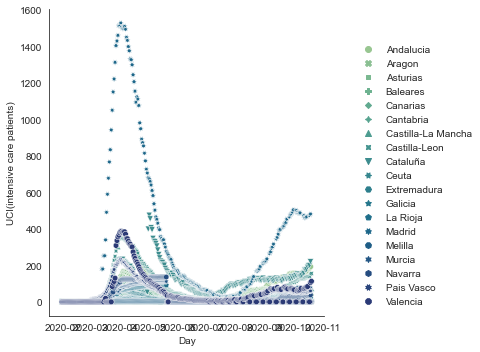

In [53]:
# Plot each day's time series in its own facet
# fig, ax = plt.subplots(figsize=(14,6))
fig = plt.gcf()

# Change seaborn plot size
fig.set_size_inches(32, 16)

sns.set_style('white')

g = sns.relplot(data=ts, palette='crest', kind='scatter')

# Iterate over each subplot to customize further
for day, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(day, transform=ax.transAxes, fontweight='bold')

# #     # Plot every year's time series in the background
#     sns.lineplot(
#         data=ts, x='Date', y=ccaa, units='day',
#         ax=ax)

# # Reduce the frequency of the x axis ticks
# ax.set_xticks(ax.get_xticks())

# # Tweak the supporting aspects of the plot
g.set_titles('')
g.set_axis_labels('Day', 'UCI(intensive care patients)')
g.tight_layout();

### Folium

In [54]:
# create a plain world map
center_lat = final_df.mean().Latitude
center_long = final_df.mean().Longitude
print(center_lat, center_long)


# # communities_map = folium.Map(location=[40.416775, -3.703790], zoom_start=6, tiles='cartodbpositron')
# communities_map = folium.Map(location=[center_lat, center_long], zoom_start=6, tiles='cartodbpositron')


# # generate choropleth map 
# communities_map.choropleth(
#     geo_data=communities_geo,
#     data=final_df,
#     columns=['population', 'ccaa'],
#     key_on='feature.properties.ccaa',
#     fill_color='YlGnBu', 
#     fill_opacity=1, 
#     line_opacity=1,
#     legend_name='Births per 1000 inhabitants',
#     smooth_factor=0)

# # display map
# communities_map

NameError: name 'final_df' is not defined

## Location Allocation

### Types of hospitals

In [ ]:
hospitals_df=sheets_dict['FINALIDAD ASISTENCIAL']
hospitals_df

Types of hospitals unsuitable for hosting Covid patients.

In [ ]:
desfi_no_covid_19 = ['MATERNAL', 'INFANTIL', 'MATERNO-INFANTIL', 'PSIQUIÁTRICO','ONCOLÓGICO', 'REHABILITACIÓN PSICOFÍSICA','GERIATRÍA Y/O LARGA ESTANCIA']
len(desfi_no_covid_19)

In [ ]:
# desfi_covid_19 = ['GENERAL', 'QUIRÚRGICO','ENFERMEDADES DEL TORAX','OFTÁLMICO U ORL', 'TRAUMATOLOGÍA Y/O REHABILITACIÓN',
#                   'MÉDICO-QUIRÚRGICO', 'OTROS MONOGRÁFICOS', 'LEPROLÓGICO O DERMATOLÓGICO','OTRA FINALIDAD']
# len(desfi_covid_19)

In [ ]:
final_df = df[~df['finalidad_asisitencial'].isin(desfi_no_covid_19)]
final_df

In [ ]:
# final_df.fillna('-', inplace=True)
# final_df.head()